# Thresholding images and extracting lanes

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from utils.utils import *
%matplotlib inline

### Load calibration coefficients

In [2]:
coeff = pickle.load( open( "camera_cal/coefficients.p", "rb" ) )
mtx = coeff['mtx']
dist = coeff['dist']

### Define pipeline

In [3]:
def pipeline(img, l_thresh=(60, 255), v_thresh=(30, 100), y_thresh=(30, 255), kernel_size = 15):
    '''
    Applies different gradients to the current frame in order to detect road lanes.
    '''
    img = np.copy(img)

    # Convert to HSV color space and separate the v channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    
    channel = cv2.GaussianBlur(l_channel, (kernel_size, kernel_size), 0)
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    hls_l_binary = np.zeros_like(scaled_sobel)
    hls_l_binary[(scaled_sobel >= l_thresh[0]) & (scaled_sobel <= l_thresh[1])] = 1

    # Convert to YUV
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV).astype(np.float)
    y_channel = yuv[:,:,0]
    v_channel = yuv[:,:,2]
    
    channel = cv2.GaussianBlur(y_channel, (kernel_size, kernel_size), 0)
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    yuv_y_binary = np.zeros_like(scaled_sobel)
    yuv_y_binary[(scaled_sobel >= y_thresh[0]) & (scaled_sobel <= y_thresh[1])] = 1

    white = np.zeros_like(scaled_sobel)
    white[(hls_l_binary == 1) | (yuv_y_binary == 1)] = 1

    channel = cv2.GaussianBlur(v_channel, (kernel_size, kernel_size), 0)
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    yellow = np.zeros_like(scaled_sobel)
    yellow[(scaled_sobel >= v_thresh[0]) & (scaled_sobel <= v_thresh[1])] = 1

    combined = np.zeros_like(scaled_sobel)
    combined[(yellow == 1) | (white == 1)] = 1
    return combined

### Load video frame

In [17]:
from moviepy.editor import *
video_file = "test_videos/harder_challenge_video.mp4"
video = VideoFileClip(video_file)
a = video.iter_frames()

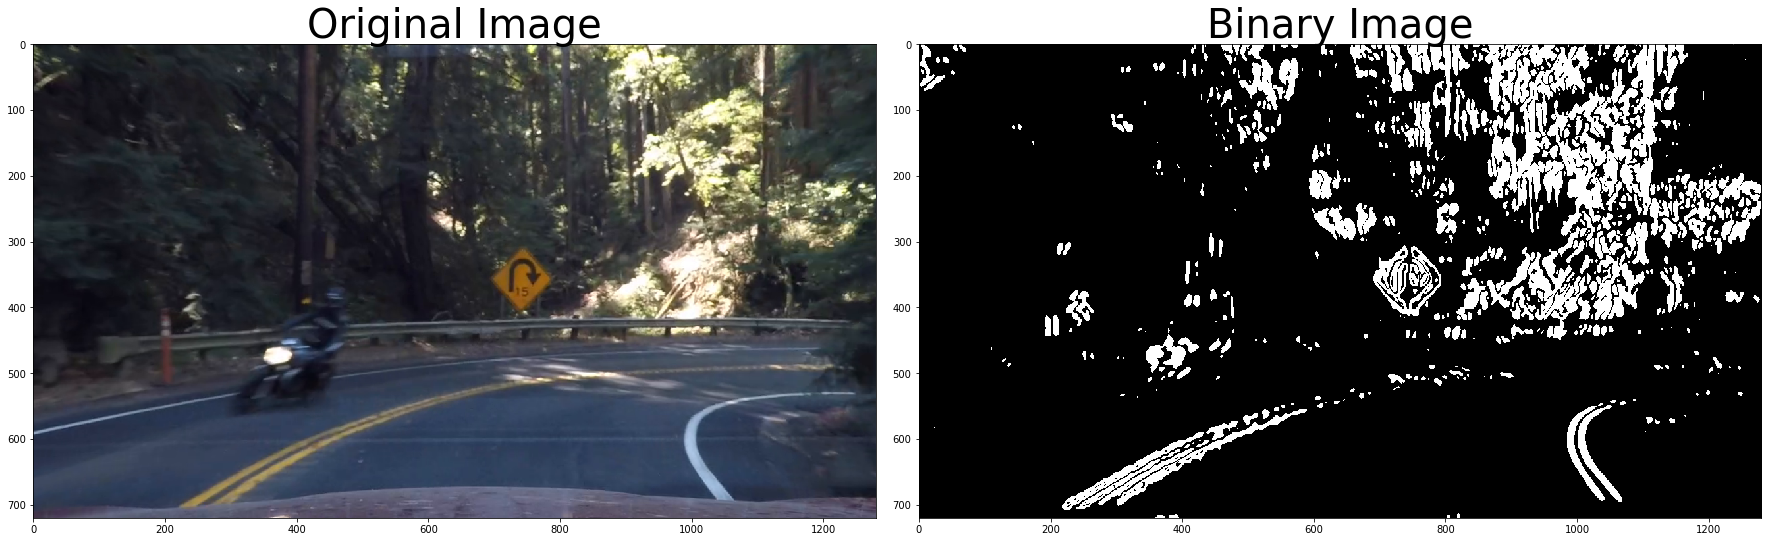

In [119]:
for i in range(1):
    frame = next(a)

#time = 0
#frame = video.get_frame(time)

undistorted = undistort(frame,mtx,dist)
result = pipeline(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

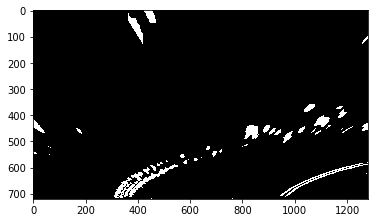

In [121]:
undistorted, thresholded, top_down = process_frame(frame,mtx,dist)
plt.imshow(top_down,cmap='gray')

(720, 0)

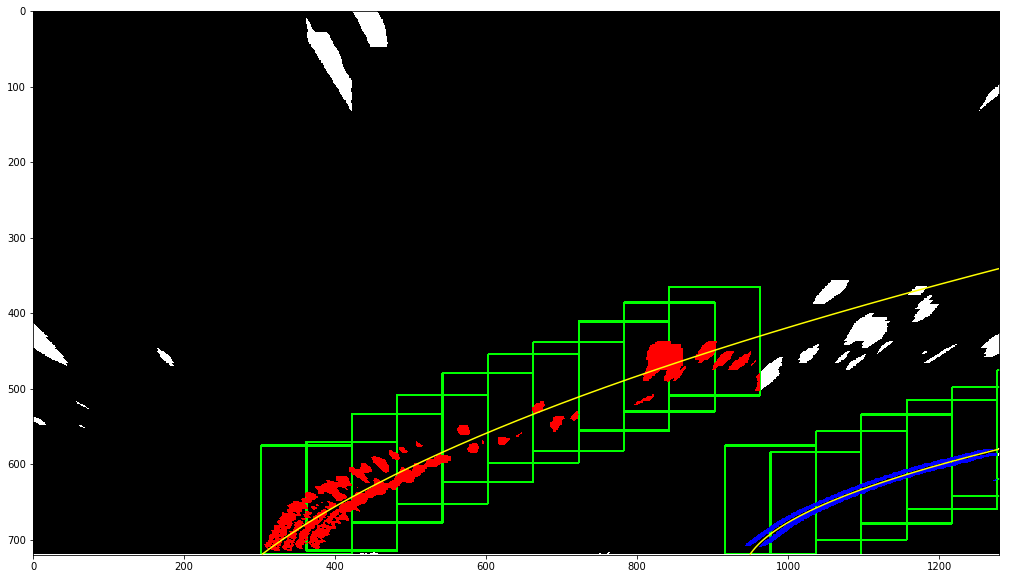

In [122]:
leftx_base, rightx_base = find_lanes_hist(top_down)
left_fit, right_fit, left_curverad, right_curverad, out_img = get_polynomial(top_down, leftx_base, rightx_base, debug=True)

# Generate x and y values for plotting
ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(720, 0)

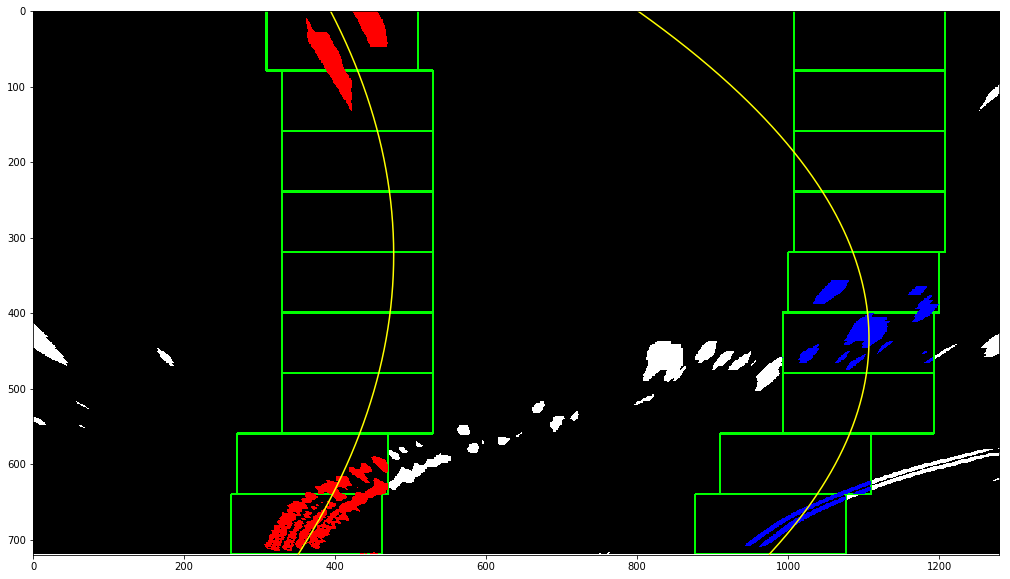

In [124]:
leftx_base, rightx_base = find_lanes_hist(top_down)
left_fit, right_fit, left_curverad, right_curverad, out_img = original_function(top_down, leftx_base, rightx_base)

# Generate x and y values for plotting
ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [123]:
def original_function(binary_warped, leftx_base, rightx_base):
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, 0, 0, out_img

In [50]:
temporal = cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR)
cv2.imwrite('./output_images/test_image.jpg', temporal)

True

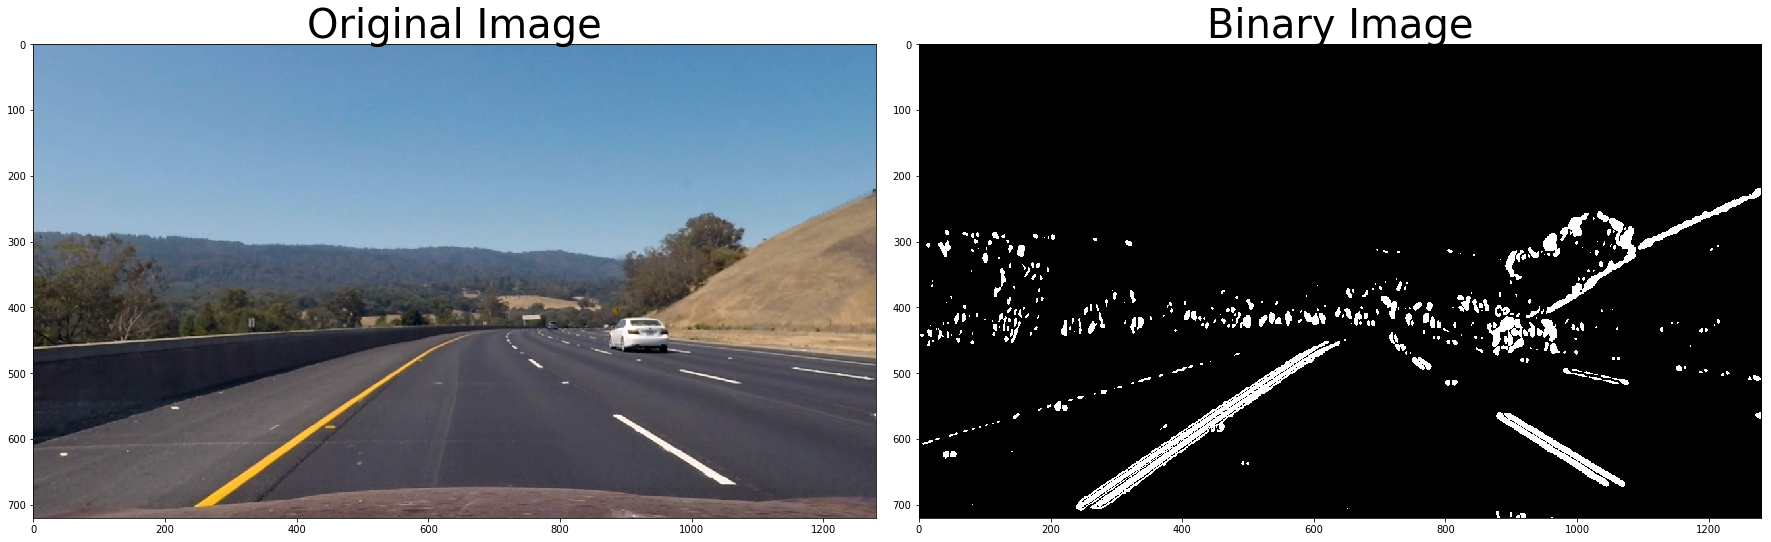

In [24]:
frame = cv2.imread('./test_images/test3.jpg')

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
undistorted = undistort(frame,mtx,dist)
result = pipeline(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Defining filters

In order to define the pipeline function presented above, I had to analyse different color spaces and I had to try several conbinations in order to find a robust set of filters. Below, I present a short description of each color space.

### 1. Analysing HLS color space

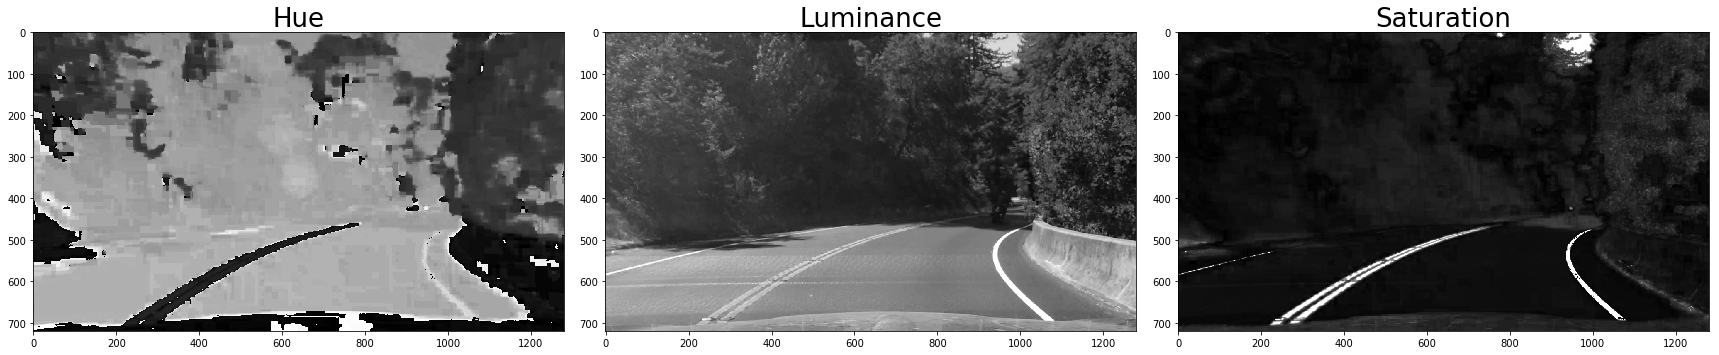

In [37]:
original = np.copy(undistorted)
# Convert to hls color space and separate the V channel
hls = cv2.cvtColor(original, cv2.COLOR_RGB2HLS).astype(np.float)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(h_channel, cmap='gray')
ax1.set_title('Hue', fontsize=26)
ax2.imshow(l_channel, cmap='gray')
ax2.set_title('Luminance', fontsize=26)
ax3.imshow(s_channel, cmap='gray')
ax3.set_title('Saturation', fontsize=26)

The _Luminance_ channel in HLS space ended up being quite useful when detecting the white lanes on the road under different illumination conditions. Below, we have an example of a filter extracting the white lanes in the image. 

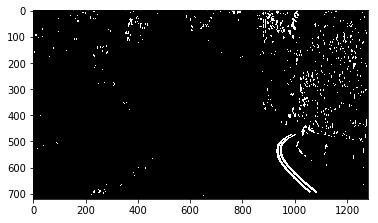

In [38]:
thr = (60,255)
kernel_size = 15
channel = cv2.GaussianBlur(l_channel, (kernel_size, kernel_size), 0)
sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
hls_l_binary = np.zeros_like(scaled_sobel)
hls_l_binary[(scaled_sobel >= thr[0]) & (scaled_sobel <= thr[1])] = 1

plt.imshow(hls_l_binary, cmap='gray')

The _Saturation_ channel can also be used for detecting both lanes:

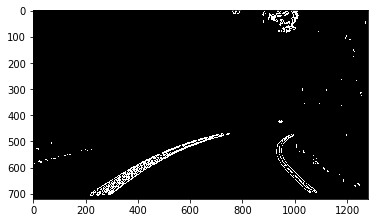

In [39]:
thr = (25,100)
kernel_size = 15
channel = cv2.GaussianBlur(s_channel, (kernel_size, kernel_size), 0)
sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
hls_s_binary = np.zeros_like(scaled_sobel)
hls_s_binary[(scaled_sobel >= thr[0]) & (scaled_sobel <= thr[1])] = 1

plt.imshow(hls_s_binary, cmap='gray')

### 2. Analysing YUV color space

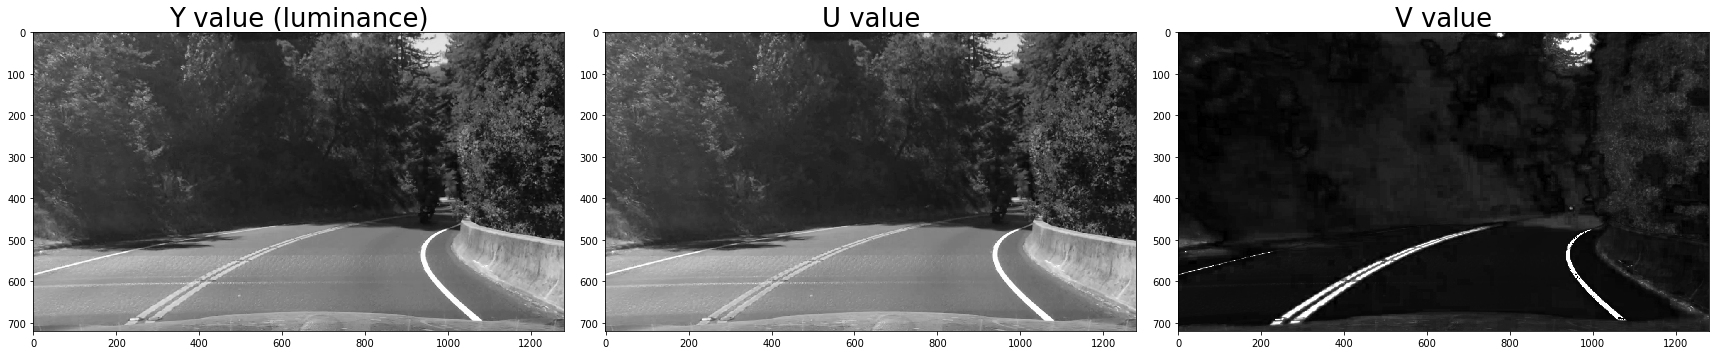

In [40]:
original = np.copy(undistorted)
# Convert to HSV color space and separate the V channel
yuv = cv2.cvtColor(original, cv2.COLOR_RGB2YUV).astype(np.float)
y_channel = yuv[:,:,0]
u_channel = yuv[:,:,1]
v_channel = yuv[:,:,2]
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(y_channel, cmap='gray')
ax1.set_title('Y value (luminance)', fontsize=26)
ax2.imshow(l_channel, cmap='gray')
ax2.set_title('U value', fontsize=26)
ax3.imshow(s_channel, cmap='gray')
ax3.set_title('V value', fontsize=26)

The _V-value_ in the YUV space ended up being the most robust channel for detecting the yellow lanes on the road after trying several parameters.

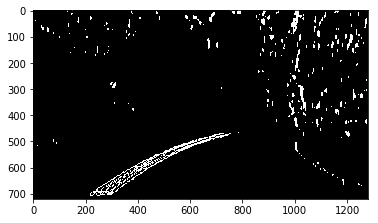

In [41]:
thr = (30,100)
kernel_size = 15
channel = cv2.GaussianBlur(v_channel, (kernel_size, kernel_size), 0)
sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
yuv_v_binary = np.zeros_like(scaled_sobel)
yuv_v_binary[(scaled_sobel >= thr[0]) & (scaled_sobel <= thr[1])] = 1

plt.imshow(yuv_v_binary, cmap='gray')

The _Y-value_ can also be used for detecting the lanes in different illumination conditions.

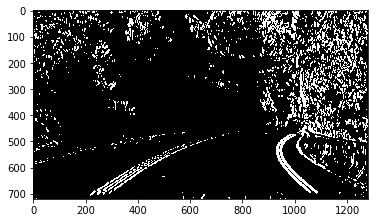

In [42]:
thr = (30,255)
kernel_size = 15
channel = cv2.GaussianBlur(y_channel, (kernel_size, kernel_size), 0)
sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
yuv_y_binary = np.zeros_like(scaled_sobel)
yuv_y_binary[(scaled_sobel >= thr[0]) & (scaled_sobel <= thr[1])] = 1

plt.imshow(yuv_y_binary, cmap='gray')

### 3. Analysing HSV color space

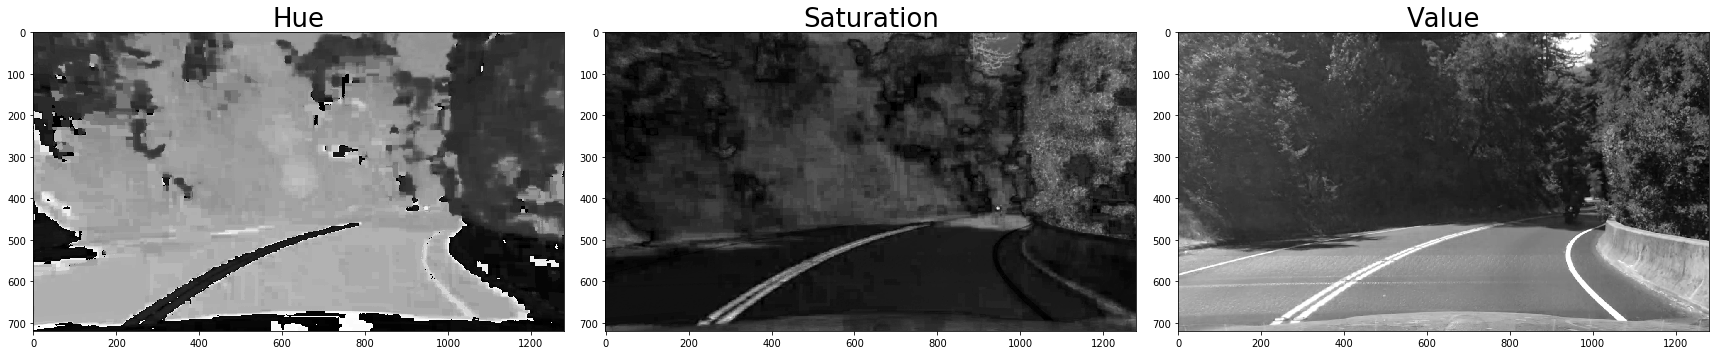

In [43]:
original = np.copy(undistorted)
# Convert to HSV color space and separate the V channel
hsv = cv2.cvtColor(original, cv2.COLOR_RGB2HSV).astype(np.float)
h_channel = hsv[:,:,0]
s_channel = hsv[:,:,1]
v_channel = hsv[:,:,2]
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(h_channel, cmap='gray')
ax1.set_title('Hue', fontsize=26)
ax2.imshow(s_channel, cmap='gray')
ax2.set_title('Saturation', fontsize=26)
ax3.imshow(v_channel, cmap='gray')
ax3.set_title('Value', fontsize=26)

Only the _Value channel_ showed some good results, but I didn't use this color space in the final pipeline.

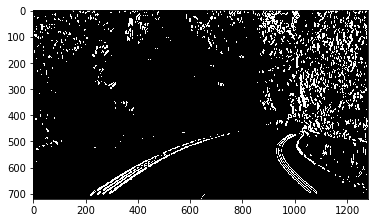

In [44]:
thr = (40,150)
kernel_size = 15
channel = cv2.GaussianBlur(v_channel, (kernel_size, kernel_size), 0)
sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
sxbinary2 = np.zeros_like(scaled_sobel)
sxbinary2[(scaled_sobel >= thr[0]) & (scaled_sobel <= thr[1])] = 1

plt.imshow(sxbinary2, cmap='gray')

## Combining filters:

### 1. Detecting yellow lane

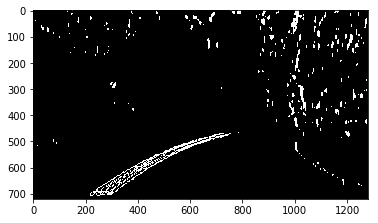

In [70]:
yellow = np.zeros_like(sxbinary2)
yellow[(yuv_v_binary == 1)] = 1

plt.imshow(yellow, cmap='gray')

### 2. Detecting white lane

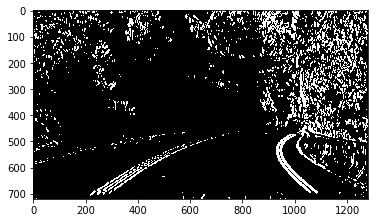

In [46]:
white = np.zeros_like(sxbinary2)
white[(hls_l_binary == 1) | (yuv_y_binary == 1)] = 1

plt.imshow(white, cmap='gray')

### 3. Merging results

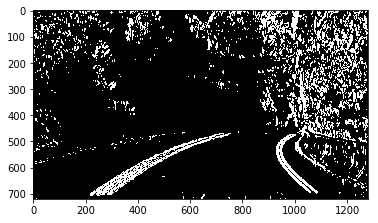

In [47]:
combined = np.zeros_like(sxbinary2)
combined[(white == 1) | (yellow == 1)] = 1

plt.imshow(combined, cmap='gray')